In [748]:
%load_ext autoreload
%autoreload 2

import sys
import math
import pickle 
import joblib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from random import sample

%matplotlib inline

import alibi
from alibi.explainers import CounterfactualProto, Counterfactual
from alibi.utils.mapping import ohe_to_ord, ord_to_ohe
import dice_ml

import warnings
warnings.filterwarnings('ignore')

sys.path.append('../')

from src.training.caseci import *
from src.explainers import *
from src.timelimit import *
from src.explainers import *

pd.set_option('display.max_columns', 500)

import tensorflow as tf
# tf.get_logger().setLevel(40)
# tf.compat.v1.disable_v2_behavior()
tf.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'1.15.0'

## Get a model

In [2]:
case = CaseCI()

In [3]:
case.train_model()

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 w

In [4]:
case.save_pipe(1, 'case_mean_imp')

ROC AUC train :  0.6738824367934839 
 ROC AUC val :  0.6408452273092748 
 ROC AUC test :  0.6412330366802789 

Precision test :  0.8477747144545097
Recall test :  0.7040641099026903


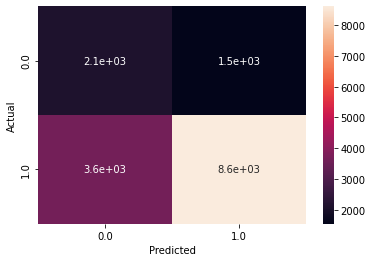

In [5]:
case.print_metrics()

## Changeable features

1.	Общее количество сделок, заключенных с организацией на текущий день. С ростом количества открытых сделок на одного клиента вероятность отказа снижается на 10%. Формулировка задачи: «Проверь по своим клиентам соблюдение контактной политики. Старайся оперативно реагировать на потребности клиента». Выводим, если менее 5 открытых сделок на одного клиента
F_5 (PDP-plot)
2.	Доля завершенных звонков среди всех активностей за 3 дня. С ростом доли звонков среди всех активностей вероятность отказа растет на 1%. «Старайся поддерживать очный контакт с клиентами». Выводим, если более 0.9 доля звонков.
F_12 (PDP-plot)
3.	Среднее количество уникальных продуктов, предложенных клиенту за 3 дня. С ростом количества уникальных предложенных продуктов вероятность отказа растет на 2%. «Старайся точно идентифицировать потребности клиента и не предлагать новые продукты без необходимости». Выводим, если более 4 количество уникальных предложенных продуктов.
F_24 (PDP-plot)
4.	Количество уникальных продуктов, предложенных клиентам за 3 дня. С ростом числа уникальных предложенных продуктов у клиента вероятность отказа растет на 0.9%. «Старайся не предлагать большой ряд продуктов, уточни потребность клиента». Выводим, если более 15 уникальных предложенных клиентам продуктов.
F_18 (PDP-plot)
5.	Среднее количество завершенных встреч и завершенных звонков за 3 дня. Если совершать встречи, вероятность отказа снижается на 0.4%. «Старайся поддерживать очный контакт с клиентом». Выводим, если нет встреч и есть звонки за последние 3 дня.
F_15, F_72 (PDP-plot)



## DiCE Report

### Generate counterfactuals for a sample n=100 using only changeable features

In [206]:
features_to_vary = ['F_5', 'F_12', 'F_24', 'F_18', 'F_15', 'F_72']

In [306]:
dice = DiCeReport(case, desired_class=0)
dice.create_explainer(method='random')

In [307]:
# example for one instance
dice.get_cf(90, features_to_vary=features_to_vary,printout=True)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.74s/it]

Query instance (original outcome : 1)


,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,0.2,1.0,0.326982,0.0,0.333333,0.019608,0.0,0.666667,0.0,0.142857,0.0,0.105263,0.916667,0.113159,0.021441,0.015385,0.0,0.504631,0.094241,0.04,0.107527,0.280724,0.365854,0.0,0.025385,0.0,0.3,1.0,0.0,0.182066,0.071429,1.0,0.08,0.0,0.019868,0.0,0.492341,0.0,0.003722,0.001788,0.536585,0.142857,0.019685,0.007938,0.058824,0.13198,0.21844,0.033149,0.052494,0.053875,0.0,0.153846,0.0,0.769231,0.09901,0.0,0.577845,1.0,0.0,0.011425,0.0,0.0,0.412747,0.017094,0.0,0.0,0.076923,1.0,0.321242,0.471278,0.0,0.013975,0.017002,0.269881,0.0,0.0,0.0,0.928571,0.0,0.007668,0.0,0.0,0.0,0.0,0.662129,1



Diverse Counterfactual set (new outcome: 0.0)


,F_0,F_1,F_2,F_3,F_4,F_5,F_6,F_7,F_8,F_9,F_10,F_11,F_12,F_13,F_14,F_15,F_16,F_17,F_18,F_19,F_20,F_21,F_22,F_23,F_24,F_25,F_26,F_27,F_28,F_29,F_30,F_31,F_32,F_33,F_34,F_35,F_36,F_37,F_38,F_39,F_40,F_41,F_42,F_43,F_44,F_45,F_46,F_47,F_48,F_49,F_50,F_51,F_52,F_53,F_54,F_55,F_56,F_57,F_58,F_59,F_60,F_61,F_62,F_63,F_64,F_65,F_66,F_67,F_68,F_69,F_70,F_71,F_72,F_73,F_74,F_75,F_76,F_77,F_78,F_79,F_80,F_81,F_82,F_83,F_84,target
0,-,-,-,-,-,1.0999999999999999,-,-,-,-,-,-,0.2,-,-,1.0153846152284023,-,-,-,0.0,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,0.0,-,-,-,1.0037216645990752,1.001788055070413,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,1.0999999999999999,-,-,-,-,-,-,-,-,-,1.0999999999999999,-,-,-,0.0,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,0.0,-,-,-,1.0037216645990752,1.001788055070413,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,1.0999999999999999,-,-,-,-,-,-,-,-,-,1.0999999999999999,-,-,-,0.0,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,0.0,-,-,-,1.0037216645990752,1.001788055070413,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,1.0999999999999999,-,-,-,-,-,-,-,-,-,1.0153846152284023,-,-,-,0.0,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,0.0,-,-,-,1.0037216645990752,1.001788055070413,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,1.0999999999999999,-,-,-,-,-,-,-,-,-,1.0999999999999999,-,-,-,0.0,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,0.0,-,-,-,1.0037216645990752,1.001788055070413,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.0


In [308]:
%%capture --no-display
dice.evaluate_dataset(n = 1000, save=True, 
                      features_to_vary=features_to_vary, 
                      name='case_dice_cf_2')

  0%|          | 0/1000 [00:00<?, ?it/s]

Резуьтат симуляции на подвыборке

In [309]:
dice.print_metrics()

1000 instances analyzed
5.1% of successfull explanations
20.7% of programming package errors
74.2% of cases, where no CFs could be found by DiCE
1.5% of additional successes (model quality adjusted)


Как DiCE менял фичи:

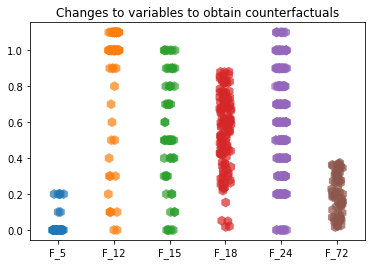

In [512]:
dice.plot_diffs()

### Generate counterfactuals for a sample n=100 using all features

In [143]:
%%capture --no-display
dice2 = DiCeReport(case, desired_class=0)
dice2.create_explainer()
dice2.evaluate_dataset(n=100, save=True, 
               name='case_dice_cf_all_feats',
               timeout=20) 
#increased timeout because all features take longer time to vary

  0%|          | 0/100 [00:00<?, ?it/s]

In [144]:
dice2.print_metrics()

100 instances analyzed
14.0% of successfull explanations
86.0% of programming package errors
0.0% of cases, where no CFs could be found by DiCE
4.0% of additional successes (model quality adjusted)


## LimeReport

  0%|          | 0/30 [00:00<?, ?it/s]

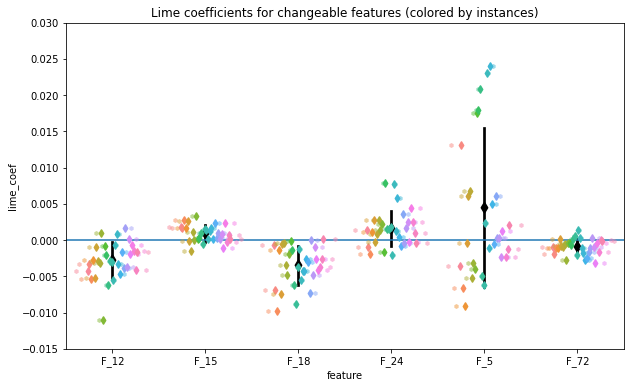

In [763]:
lime = LimeReport(case, desired_class=0)
lime.create_explainer()
lime.evaluate_dataset(n=30,features_to_vary=features_to_vary)
lime.plot_coefs(-0.015,0.03)

We can see that several features have lime coefficients with different sign for the same instances, means are very close to zero. 

At the same time, for F_18 and F_12 coefficients are negative, and it doesn't support the DiCE decision to increase the values of this features.

## SLIME - try stable LIME implementation (KDD 2021)

  0%|          | 0/30 [00:00<?, ?it/s]

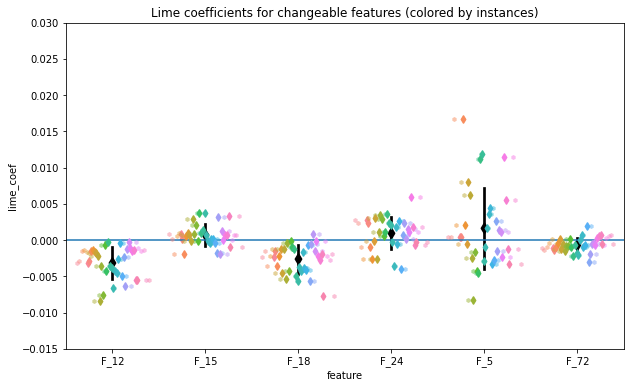

In [764]:
lime = LimeReport(case, desired_class=0, slime=True)
lime.create_explainer()
lime.evaluate_dataset(n=30,features_to_vary=features_to_vary)
lime.plot_coefs(-0.015,0.03)

## Compare results for DiCE and LIME

In [729]:
comp = Comparator(model=case, dice=dice)
comp.compare_dice_lime(features_to_vary)

  0%|          | 0/51 [00:00<?, ?it/s]

Share of cases where mean LIME coeffitient sign corresponds to DiCE suggestion sign:
         % of corresponding signs
feature                          
F_18                     0.000000
F_12                     0.028571
F_5                      0.085714
F_72                     0.300000
F_15                     0.500000
F_24                     0.787234


In [692]:
tmp = comp.long.query('instance_id==160')

Text(0.5, 0, 'dice difference btw CF and original')

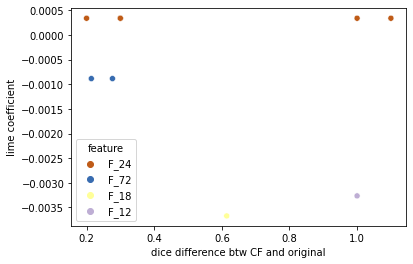

In [699]:
sns.scatterplot(x='dice_diff', y='mean', hue='feature', data=tmp, palette='Accent_r')
plt.ylabel('lime coefficient')
plt.xlabel('dice difference btw CF and original')

In [710]:
df = comp.long.copy()
df['one_sign'] = ~((df['dice_diff'] > 0) ^ (df['mean'] > 0))

## Explainers draft

In [260]:
import shap 
shap.initjs()
explainer = shap.TreeExplainer(case.grid_pipe_lgbm.best_estimator_)
shap_values = explainer.shap_values(case.X_test)

In [261]:
k = 76
shap.force_plot(explainer.expected_value[1], 
                shap_values[1][k,:], case.X_test.iloc[k,:])

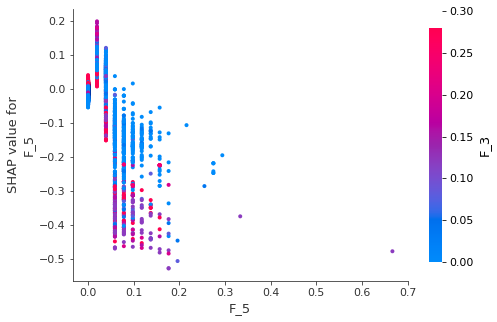

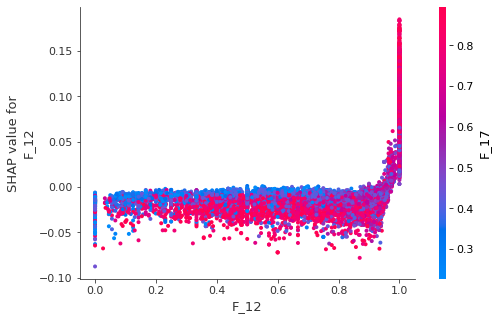

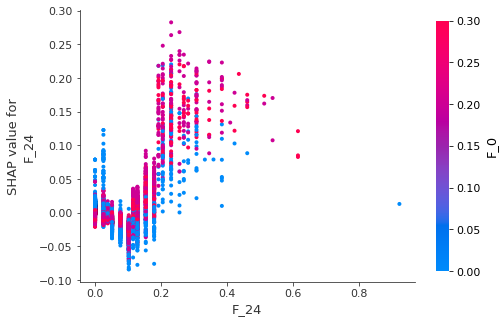

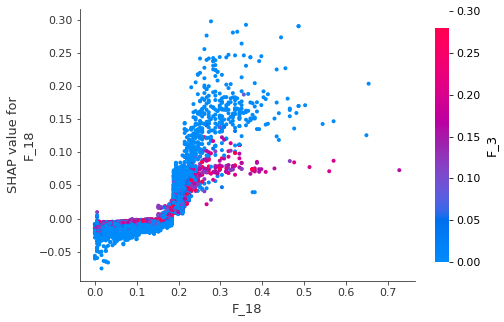

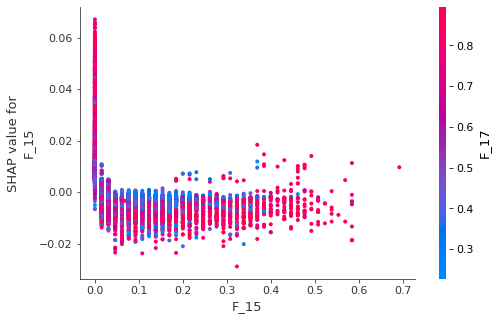

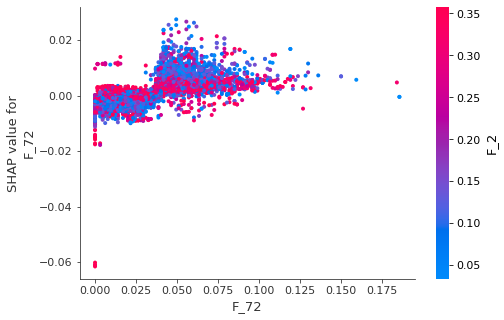

In [263]:
for name in features_to_vary:
    shap.dependence_plot(name, shap_values[1], case.X_test, 
                         display_features=case.X_test)

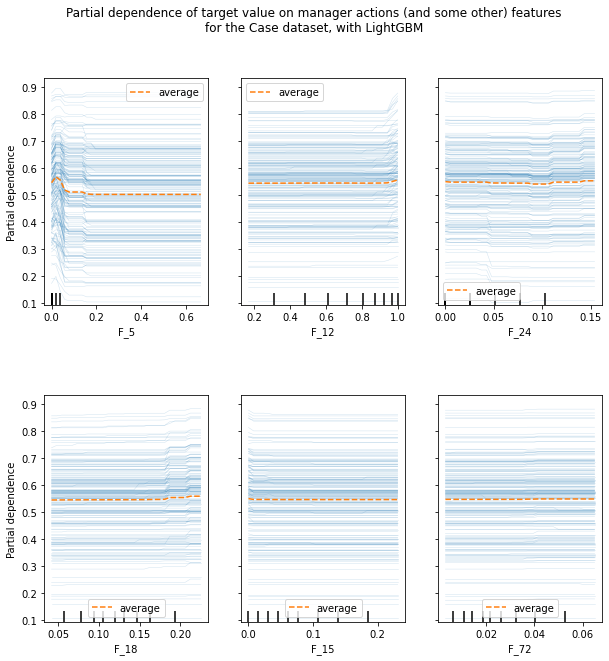

In [325]:
features = features_to_vary
title_fill = ['manager actions (and some other) features', 
              'Case', 'LightGBM']
plot_pdp_ice(case.grid_pipe_lgbm, case.X_train, features, title_fill)